In [133]:
import pandas as pd
import numpy as np

import networkx as nx

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from tqdm.notebook import tqdm

import ast

from fa2 import ForceAtlas2

import nltk

import re

import utils

In [3]:
tqdm.pandas()

In [45]:
df= pd.read_csv("../data/marvel_characters.csv")

df["links"] = df["links"].progress_apply(ast.literal_eval)
df["links"] = df["links"].progress_apply(lambda x: list(set(x)))
df["number_links"] = df["links"].progress_apply(lambda x: len(x))
df["gender"] = df["gender"].progress_apply(ast.literal_eval)
df["gender"] = df["gender"].progress_apply(lambda x: x[-1].split(" ")[0]
                                           if len(x)
                                           and len(x[-1])
                                           else "Unknown"
                                          )


df = df.drop(columns=['Unnamed: 0'])

df

  0%|          | 0/29998 [00:00<?, ?it/s]

  0%|          | 0/29998 [00:00<?, ?it/s]

  0%|          | 0/29998 [00:00<?, ?it/s]

  0%|          | 0/29998 [00:00<?, ?it/s]

  0%|          | 0/29998 [00:00<?, ?it/s]

,title,pageid,imglink,gender,links,number_links
0,'Spinner (Earth-616),322600,'Spinner (Earth-616) from Marvel Comics Presen...,Male,[],0
1,01100010 01110010 01110101 01110100 01100101 (...,1053805,01100010 01110010 01110101 01110100 01100101 (...,Unknown,"[Rocket Raccoon (Earth-616), Cosmo (Dog) (Eart...",2
2,107 (Earth-616),116257,107 (Earth-616) from Justice Four Balance Vol ...,Male,[Vance Astrovik (Earth-616)],1
3,11-Ball (Earth-616),543479,11-Ball (Earth-616) from Sleepwalker Vol 1 2 0...,Male,"[Jeff Hagees (Earth-616), Sleepwalker (Earth-6...",2
4,115 (Legion Personality) (Earth-616),624448,115 (Legion Personality) (Earth-616) from New ...,Female,"[Scott Summers (Earth-616), James Bradley (Ear...",6
...,...,...,...,...,...,...
29993,Äkräs (Earth-616),674537,Äkräs (Earth-616) from Thor & Hercules Encyclo...,Male,"[Gaea (Earth-616), Ukko (Earth-616)]",2
29994,Ériu (Earth-616),1120186,No Image Available At All.png,Female,"[Iarbonel (Earth-616), Elathan (Earth-616), Le...",10
29995,Ögedei Khan (Earth-616),1573347,No Image Available At All.png,Male,"[Druig (Earth-616), Kingo Sunen (Earth-616), T...",4
29996,Øde (Earth-616),1376944,Øde_(Earth-616)_from_Valkyrie-_Jane_Foster_Vol...,Male,"[Thor Odinson (Earth-616), Odin Borson (Earth-...",5


In [46]:
def connect_node(row, g):
 
  g.add_node(row["title"], gender=row["gender"])
  
  for link in row["links"]:
    g.add_edge(row["title"], link)

def createGraph(df, directed=False):
  
  g = nx.Graph()
  
  if directed:
    g = nx.DiGraph()

  _ = df.progress_apply(connect_node, g=g, axis=1)
    
  return g

In [51]:
g = createGraph(df)

  0%|          | 0/29998 [00:00<?, ?it/s]

In [52]:
print("Graph basic stats:")
print(f"\tNumber of nodes: {len(g.nodes)}")
print(f"\tNumber of edges: {len(g.edges)}")
print(f"\tAverage degree: {sum(x[1] for x in g.degree)/len(g.degree):.2f}")
print()
print(f"\tMost connected node: {max(g.degree, key=lambda x: x[1])[0]} \
with a degree of {max(g.degree, key=lambda x: x[1])[1]}")

Graph basic stats:
	Number of nodes: 29998
	Number of edges: 97926
	Average degree: 6.53

	Most connected node: Steven Rogers (Earth-616) with a degree of 1286


In [53]:
df.sort_values(by=["number_links"], ascending=False).head()

,title,pageid,imglink,gender,links,number_links
15477,Krakoa (Earth-616),77192,Krakoa (Earth-616) from X-Men Vol 5 16 001.jpg,Agender,"[Claudette and Nicole St. Croix (Earth-616), R...",335
3692,Bruce Banner (Earth-616),1833,Immortal Hulk Vol 1 20 Unknown Comic Books Exc...,Male,"[Dormammu (Earth-616), Nicholas Trask (Earth-6...",264
12571,James Howlett (Earth-616),64786,James Howlett (Earth-616) from Wolverine Vol 7...,Male,"[John Howlett, Jr. (Earth-616), Matsu'o Tsuray...",255
21537,Peter Parker (Earth-616),1678,Friendly Neighborhood Spider-Man Vol 2 8 Grano...,Male,"[Priscilla Ironwood (Earth-616), Adriana Soria...",220
29043,William Baker (Earth-616),2382,Amazing Spider-Man Vol 1 615 Villain Variant T...,Male,"[Stanley Osborn (Earth-616), Richard Jones (Ea...",209


In [54]:
gcc = g.subgraph(max(nx.connected_components(g), key=len))

print(f"Number of nodes in the GCC: {len(gcc.nodes)}\nNumber of links in GCC: {len(gcc.edges)}")

Number of nodes in the GCC: 23670
Number of links in GCC: 96512


In [57]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=0.5,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=10.0,
                          strongGravityMode=False,
                          gravity=10.0,

                          # Log
                          verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(gcc, pos=None, iterations=50)

100%|███████████████████████████████████████████| 20/20 [04:58<00:00, 14.95s/it]

BarnesHut Approximation  took  12.00  seconds
Repulsion forces  took  280.56  seconds
Gravitational forces  took  0.50  seconds
Attraction forces  took  4.03  seconds
AdjustSpeedAndApplyForces step  took  1.61  seconds


In [68]:
colors = []
sizes = []
alphas = []
max_degree = max(gcc.degree(), key=lambda x: x[1])[1]

for node in tqdm(gcc.nodes):
  color = np.array([0, 0, 0])
  size = gcc.degree(node) * 20 + 15
  alpha = max([gcc.degree(node)/max_degree, .2])
  
  red = gcc.degree(node) * 255 / max_degree
  green = 0
  blue = 0
  
  color = np.array([red, green, blue])
  
  colors.append(color/255)
  sizes.append(size)
  alphas.append(alpha)

  0%|          | 0/23670 [00:00<?, ?it/s]

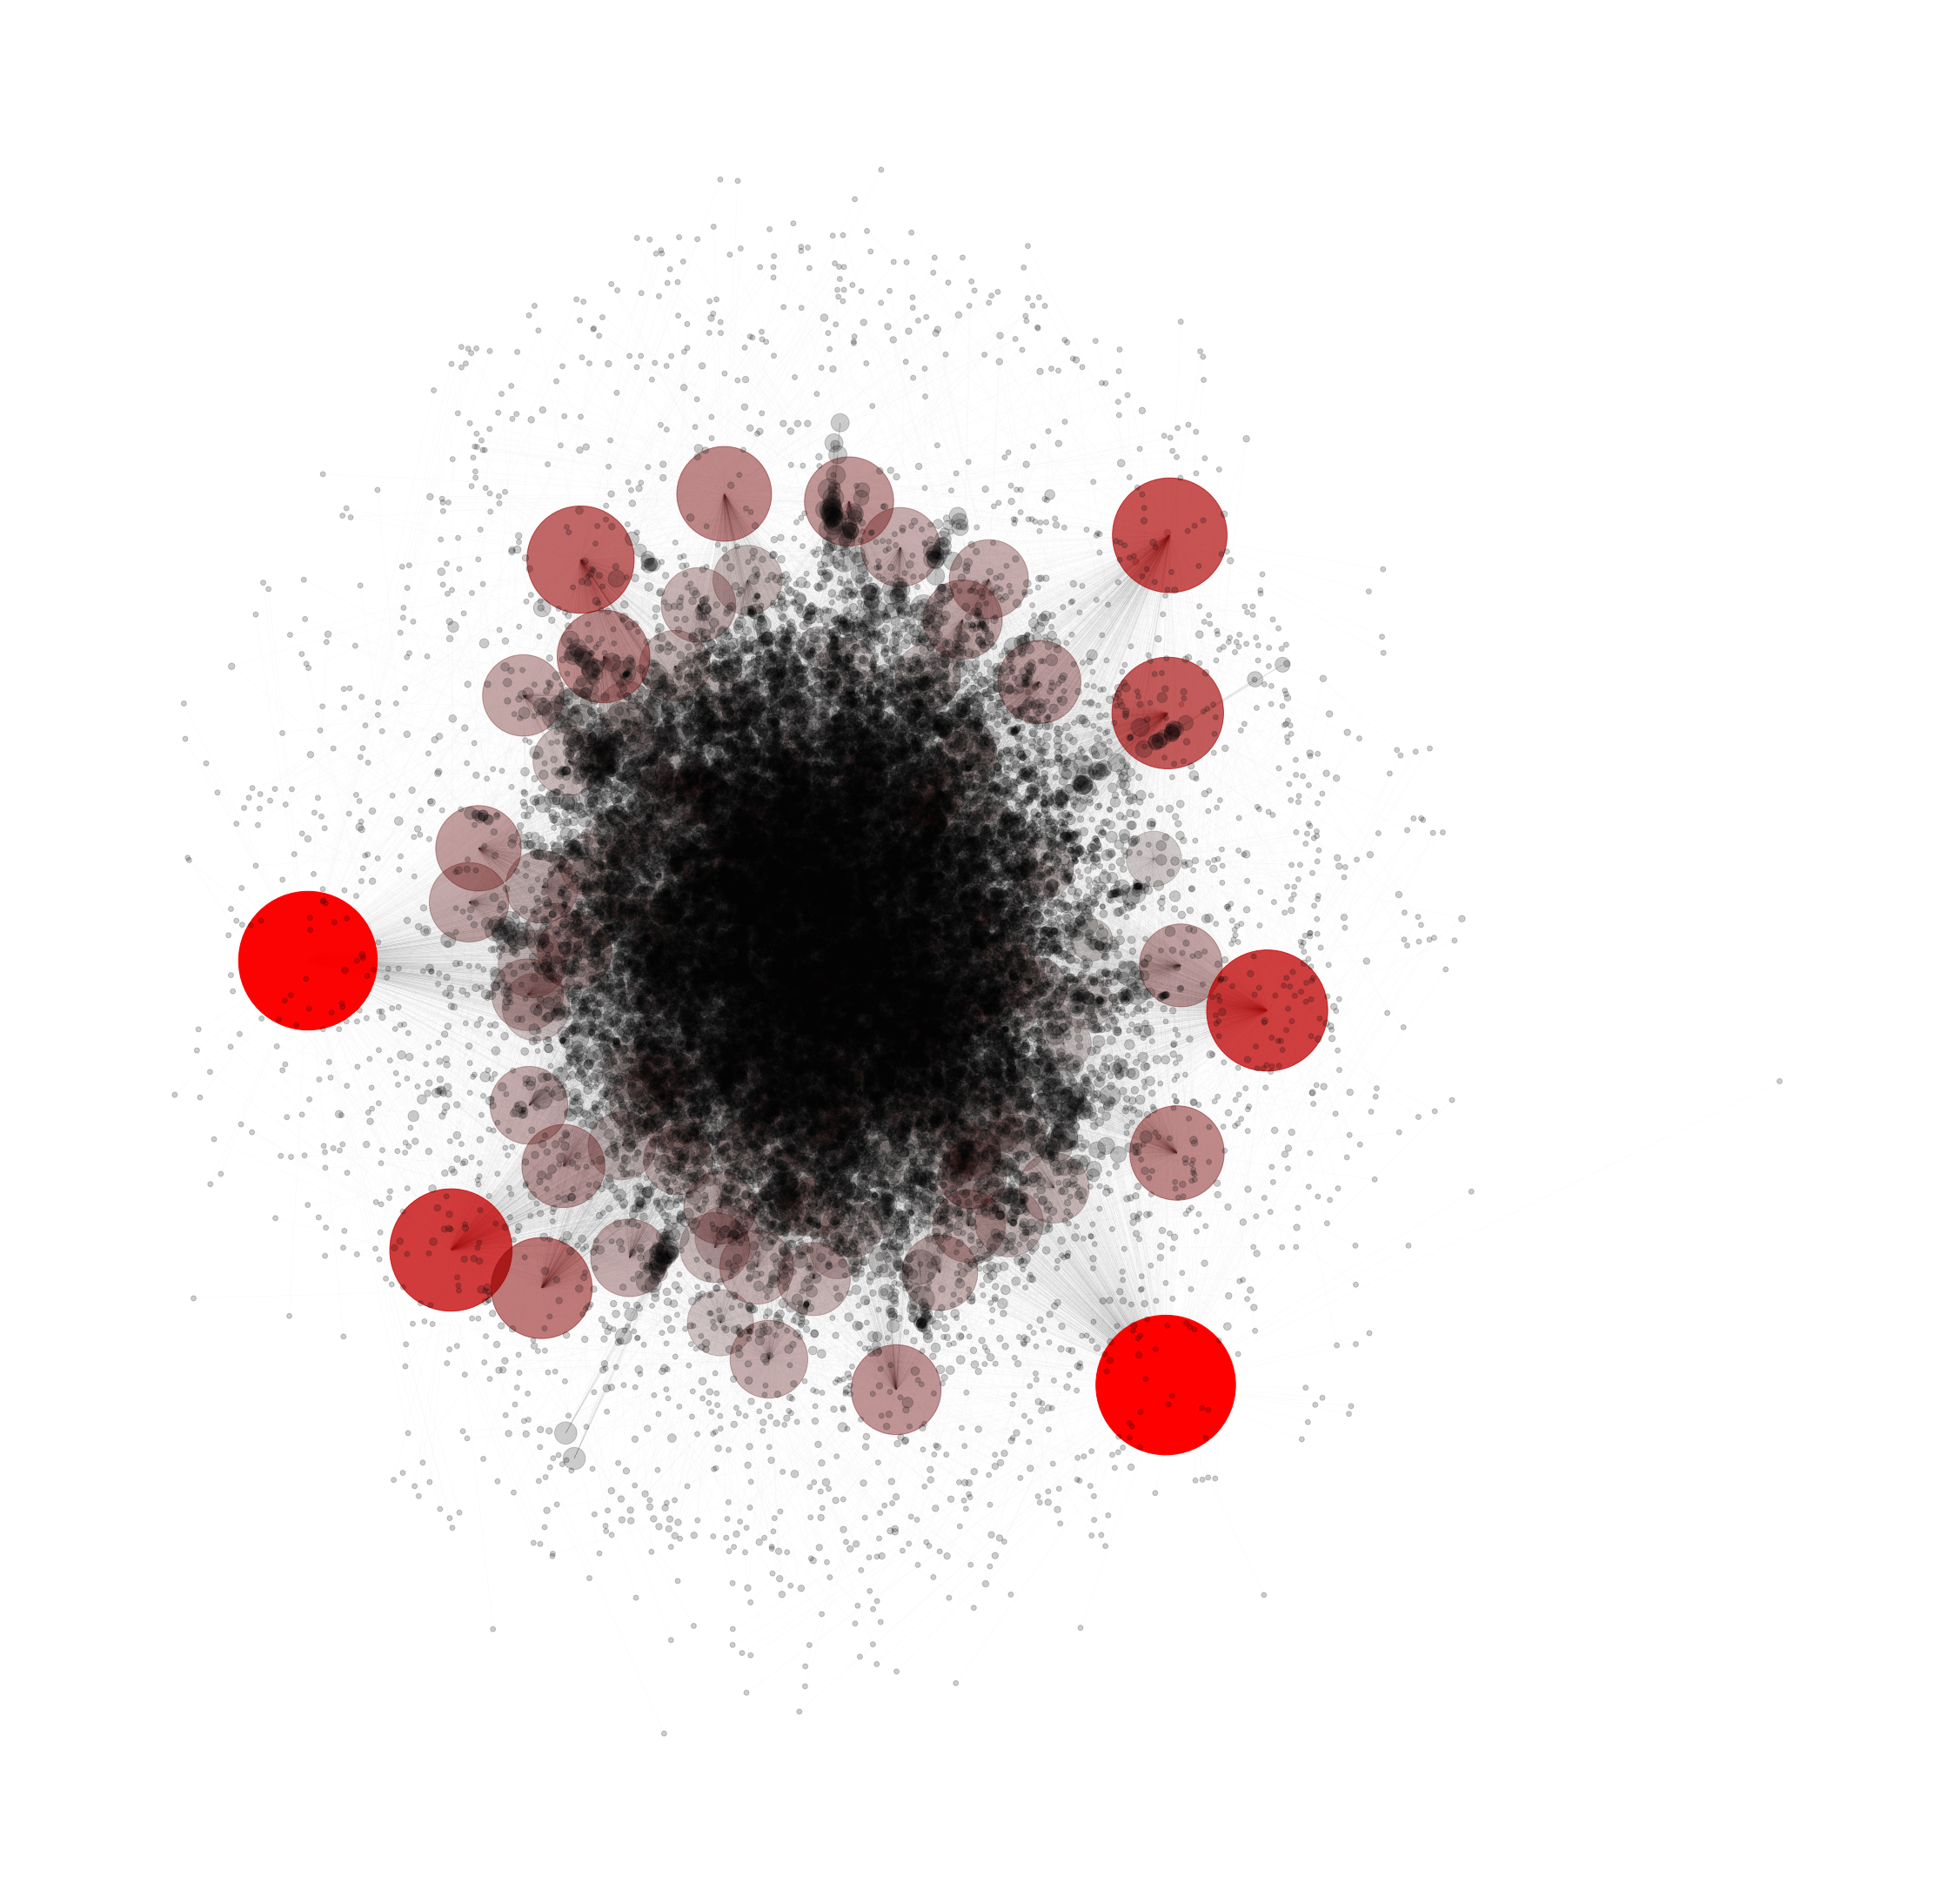

In [70]:
fig, ax = plt.subplots(figsize=(40, 40))

nx.draw_networkx_nodes(gcc,
                       positions,
                       linewidths  = 1,
                       node_size   = sizes,
                       node_color  = colors,
                       alpha       = alphas,
                       ax          = ax
                      )

nx.draw_networkx_edges(gcc,
                       positions,
                       edge_color  = "black",
                       arrowstyle  = "-",
                       alpha       = 0.03,
                       width       = .5,
                       ax          = ax
                      )  
plt.axis("off")

plt.show()

In [72]:
dg = createGraph(df, directed=True)

dgcc = dg.subgraph(max(nx.weakly_connected_components(dg), key=len))

  0%|          | 0/29998 [00:00<?, ?it/s]

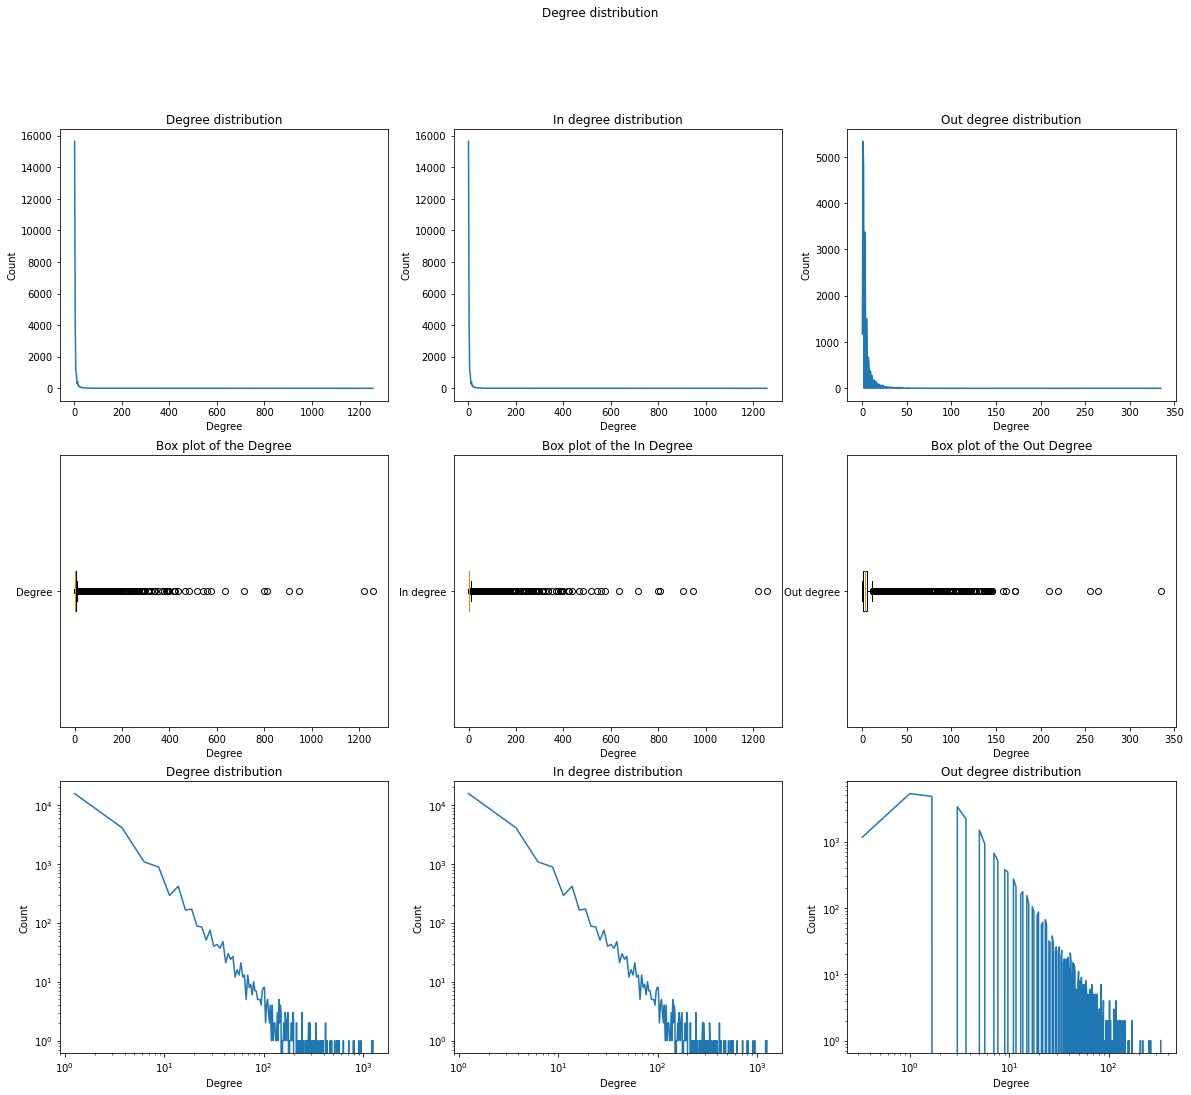

In [102]:
fig, ((ax, in_ax, out_ax),
      (ax_bp, in_ax_bp, out_ax_bp),
      (l_ax, inl_ax, outl_ax)) = plt.subplots(3, 3, figsize=(20, 17))
fig.suptitle("Degree distribution")

degrees = dict(dgcc.degree()).values()

hist, bins = np.histogram(np.array(list(degrees)), bins=500)
center = (bins[:-1] + bins[1:])/2

in_degrees = dict(dgcc.in_degree()).values()
out_degrees = dict(dgcc.out_degree()).values()

in_hist, in_bins = np.histogram(np.array(list(in_degrees)), bins=500)
in_center = (in_bins[:-1] + in_bins[1:])/2

out_hist, out_bins = np.histogram(np.array(list(out_degrees)), bins=500)
out_center = (out_bins[:-1] + out_bins[1:])/2


ax.plot(in_center, in_hist)
ax.set_title("Degree distribution")
ax.set_xlabel("Degree")
ax.set_ylabel("Count")

in_ax.plot(in_center, in_hist)
in_ax.set_title("In degree distribution")
in_ax.set_xlabel("Degree")
in_ax.set_ylabel("Count")

out_ax.plot(out_center, out_hist)
out_ax.set_title("Out degree distribution")
out_ax.set_xlabel("Degree")
out_ax.set_ylabel("Count")

ax_bp.boxplot(in_degrees, vert=False, labels=["Degree"])
ax_bp.set_title("Box plot of the Degree")
ax_bp.set_xlabel("Degree")

in_ax_bp.boxplot(in_degrees, vert=False, labels=["In degree"])
in_ax_bp.set_title("Box plot of the In Degree")
in_ax_bp.set_xlabel("Degree")

out_ax_bp.boxplot(out_degrees, vert=False, labels=["Out degree"])
out_ax_bp.set_title("Box plot of the Out Degree")
out_ax_bp.set_xlabel("Degree")

l_ax.plot(in_center, in_hist)
l_ax.set_title("Degree distribution")
l_ax.set_xlabel("Degree")
l_ax.set_ylabel("Count")
l_ax.set_xscale("log")
l_ax.set_yscale("log")

inl_ax.plot(in_center, in_hist)
inl_ax.set_title("In degree distribution")
inl_ax.set_xlabel("Degree")
inl_ax.set_ylabel("Count")
inl_ax.set_xscale("log")
inl_ax.set_yscale("log")

outl_ax.plot(out_center, out_hist)
outl_ax.set_title("Out degree distribution")
outl_ax.set_xlabel("Degree")
outl_ax.set_ylabel("Count")
outl_ax.set_xscale("log")
outl_ax.set_yscale("log")

plt.show()

In [103]:
print(f"Number of nodes in network: \t {dgcc.number_of_nodes()}")
print(f"Number of links🔗: \t\t {dgcc.number_of_edges()}")

sorted_in  = sorted(dgcc.nodes, key=dgcc.in_degree, reverse=True)
sorted_out = sorted(dgcc.nodes, key=dgcc.out_degree, reverse=True)
sorted_tot = sorted(dgcc.nodes, key=dgcc.degree, reverse=True)

print(f"Most connected in:\t {sorted_in[0]}\n\tin👈:\t{dgcc.in_degree(sorted_in[0])}\n\tout👉:\t{dgcc.out_degree(sorted_in[0])}")
print(f"Most connected out:\t {sorted_out[0]}\n\tin👈:\t{dgcc.in_degree(sorted_out[0])}\n\tout👉:\t{dgcc.out_degree(sorted_out[0])}")
print(f"Most connected overall:\t {sorted_tot[0]}\n\tin👈:\t{dgcc.in_degree(sorted_tot[0])}\n\tout👉:\t{dgcc.out_degree(sorted_tot[0])}")

Number of nodes in network: 	 23670
Number of links🔗: 		 124665
Most connected in:	 Steven Rogers (Earth-616)
	in👈:	1258
	out👉:	161
Most connected out:	 Krakoa (Earth-616)
	in👈:	387
	out👉:	335
Most connected overall:	 Peter Parker (Earth-616)
	in👈:	1222
	out👉:	220


Quotes

In [123]:
def getQuotes(row):
  
  file_name = utils.generate_filename(row["title"])
  quotes = []
  with open("../data/character_quotes/"+file_name+".json") as f:
    quotes += ast.literal_eval(f.read())
  
  
  return pd.Series([quotes, len(quotes)])


df[["quotes", "number_quotes"]] = df.progress_apply(getQuotes, axis=1)
df_quotes = df[df["number_quotes"] > 0]
df_quotes.head()

  0%|          | 0/29998 [00:00<?, ?it/s]

,title,pageid,imglink,gender,links,number_links,quotes,number_quotes
14,762 (Legion Personality) (Earth-616),624450,762 (Legion Personality) (Earth-616) from New ...,Male,"[115 (Legion Personality) (Earth-616), Scott S...",4,"[Aye, Matey.. But me tinks all this rocking ha...",1
23,A'di (Earth-616),1064356,A'di (Earth-616) from Mighty Captain Marvel Vo...,Female,"[T'Challa (Earth-616), Itz (Earth-616)]",2,[I don't just want to be a soldier. I want to ...,1
26,A'Kurru U'mbaya (Earth-616),18286,A'Kurru U'mbaya (Earth-616) from Excalibur Vol...,Male,[],0,[Do not underestimate me as others have done b...,1
27,A'Lars (Earth-616),2144,A'Lars (Earth-616) from Infinity Wars Fallen G...,Male,"[Heather Douglas (Earth-616), Richard Jones (E...",21,[There is only '''one way''' to stop Thanos fr...,2
53,Aarkus (Earth-616),5557,Aarkus (Earth-616) from All-New Invaders Vol 1...,Male,"[Enoch Mason (Earth-616), Brains Borelli (Eart...",51,[It is a new age. An age of '''heroes.''' An a...,2


In [129]:
sorted_df_quotes = df_quotes.sort_values("number_quotes", ascending=False)

In [136]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
wnl = nltk.WordNetLemmatizer()

def preprocesQuotes(row):
  process_quotes = []
  for quote in row["quotes"]:
    quote = re.sub(r"[^a-zA-Z0-9\s]", " ", quote)
    tokens = tokenizer.tokenize(quote)
    all_words = [x.strip().lower() for x in tokens]
    
    stop_words = list(nltk.corpus.stopwords.words("english")) # Stopwords
    stop_words += ["im", "one"]
    
    filtered = [x for x in all_words if x not in stop_words]
    
    lemmatized = [wnl.lemmatize(w) for w in filtered]
    process_quotes.extend(lemmatized)
  
  return process_quotes

sorted_df_quotes["processed_quotes"] = sorted_df_quotes.progress_apply(preprocesQuotes, axis=1)
sorted_df_quotes.head()

  0%|          | 0/3183 [00:00<?, ?it/s]

,title,pageid,imglink,gender,links,number_links,quotes,number_quotes,processed_quotes
21537,Peter Parker (Earth-616),1678,Friendly Neighborhood Spider-Man Vol 2 8 Grano...,Male,"[Priscilla Ironwood (Earth-616), Adriana Soria...",220,[Adoma. Congratulations. You just became the f...,666,"[adoma, congratulation, became, first, winner,..."
26026,Steven Rogers (Earth-616),7139,Captain America Vol 6 2 Textless.jpg,Male,"[Rex Applegate (Earth-616), Dormammu (Earth-61...",161,[They should be proud to have her as a student...,432,"[proud, student, heck, write, letter, think, o..."
1505,Anthony Stark (Earth-616),1292982,Iron Man Vol 6 1 Brooks Variant Textless.jpg,Male,"[Mandarin (Earth-616), Reed Richards (Earth-61...",146,[There's only two things I ever managed to bel...,381,"[two, thing, ever, managed, believe, firstly, ..."
12571,James Howlett (Earth-616),64786,James Howlett (Earth-616) from Wolverine Vol 7...,Male,"[John Howlett, Jr. (Earth-616), Matsu'o Tsuray...",255,"[There ain't no sense to it, babe. There's nev...",337,"[sense, babe, never, sense, dyin, death, poiso..."
28642,Wade Wilson (Earth-616),1409,Deadpool Vol 8 1 Textless.jpg,Male,"[Todd Arliss (Earth-616), Hubert Carpenter (Ea...",171,[It's an angel of God. My glorious Bea Arthur-...,287,"[angel, god, glorious, bea, arthur, well, nath..."


In [141]:
sorted_df_quotes[["number_words",
                  "number_unique_words",
                  "lexical_richness"]] = sorted_df_quotes["processed_quotes"]\
                                        .progress_apply(lambda x: pd.Series([len(x),
                                                                            len(list(set(x))),
                                                                            len(set(x))/len(x) if len(x) > 0 else 0
                                                                            ]))

sorted_df_quotes.head()

  0%|          | 0/3183 [00:00<?, ?it/s]

,title,pageid,imglink,gender,links,number_links,quotes,number_quotes,processed_quotes,number_words,number_unique_words,lexical_richness
21537,Peter Parker (Earth-616),1678,Friendly Neighborhood Spider-Man Vol 2 8 Grano...,Male,"[Priscilla Ironwood (Earth-616), Adriana Soria...",220,[Adoma. Congratulations. You just became the f...,666,"[adoma, congratulation, became, first, winner,...",10853.0,2778.0,0.255966
26026,Steven Rogers (Earth-616),7139,Captain America Vol 6 2 Textless.jpg,Male,"[Rex Applegate (Earth-616), Dormammu (Earth-61...",161,[They should be proud to have her as a student...,432,"[proud, student, heck, write, letter, think, o...",4967.0,1762.0,0.354741
1505,Anthony Stark (Earth-616),1292982,Iron Man Vol 6 1 Brooks Variant Textless.jpg,Male,"[Mandarin (Earth-616), Reed Richards (Earth-61...",146,[There's only two things I ever managed to bel...,381,"[two, thing, ever, managed, believe, firstly, ...",4853.0,1795.0,0.369874
12571,James Howlett (Earth-616),64786,James Howlett (Earth-616) from Wolverine Vol 7...,Male,"[John Howlett, Jr. (Earth-616), Matsu'o Tsuray...",255,"[There ain't no sense to it, babe. There's nev...",337,"[sense, babe, never, sense, dyin, death, poiso...",4525.0,1586.0,0.350497
28642,Wade Wilson (Earth-616),1409,Deadpool Vol 8 1 Textless.jpg,Male,"[Todd Arliss (Earth-616), Hubert Carpenter (Ea...",171,[It's an angel of God. My glorious Bea Arthur-...,287,"[angel, god, glorious, bea, arthur, well, nath...",4227.0,1720.0,0.406908


In [146]:
print("Most well versed")
sorted_df_quotes[sorted_df_quotes["number_words"] > 500].sort_values("lexical_richness", ascending=False)

Most well versed


,title,pageid,imglink,gender,links,number_links,quotes,number_quotes,processed_quotes,number_words,number_unique_words,lexical_richness
6275,David Haller (Earth-616),1966,New Mutants Vol 3 21 Textless.jpg,Male,"[Brian Xavier (Earth-616), Hypnobloke (Legion ...",102,"[My name is Legion, for '''we''' are many!, It...",31,"[name, legion, many, never, occurred, try, mer...",675.0,445.0,0.659259
21787,Pietro Maximoff (Earth-616),1592,Pietro Maximoff (Earth-616) from Quicksilver N...,Male,"[Daniel Drumm (Earth-616), Jericho Drumm (Eart...",75,[Nothing. Nothing's going on. I'm just...it's ...,37,"[nothing, nothing, going, interesting, develop...",640.0,401.0,0.626563
18477,Mephisto (Earth-616),2146,Mephisto (Earth-616) from Loki Agent of Asgard...,Male,"[Reed Richards (Earth-616), Thaddeus Ross (Ear...",127,[You're gonna be my finest deal in a millenniu...,31,"[gonna, finest, deal, millennium, norman, osbo...",545.0,339.0,0.622018
2744,Benjamin Urich (Earth-616),1161,Benjamin Urich (Earth-616) from Defenders Vol ...,Male,"[Phillip Urich (Earth-616), Roger Gocking (Ear...",36,[My name is Ben Urich. I'm a reporter. I used ...,15,"[name, ben, urich, reporter, used, husband, fa...",546.0,339.0,0.620879
16496,Loki Laufeyson (Earth-616),2042,Loki Laufeyson (Earth-616) from Thor Vol 3 12 ...,Male,"[Dormammu (Earth-616), Loki Laufeyson (Ikol) (...",89,[Operation Firefly consists of sensitive infor...,35,"[operation, firefly, consists, sensitive, info...",539.0,334.0,0.619666
...,...,...,...,...,...,...,...,...,...,...,...,...
24472,Scott Summers (Earth-616),29481,X-Men Vol 6 1 New Line-Up Trading Card Variant...,Male,"[Alia Gregor (Earth-616), John Grey (Earth-616...",142,[If that's your way of saying we're on an endl...,139,"[way, saying, endless, honeymoon, prior, turri...",2675.0,986.0,0.368598
3692,Bruce Banner (Earth-616),1833,Immortal Hulk Vol 1 20 Unknown Comic Books Exc...,Male,"[Dormammu (Earth-616), Nicholas Trask (Earth-6...",264,[The '''angrier''' I get the '''stronger''' I ...,227,"[angrier, get, stronger, get, strongest, hulk,...",2808.0,1021.0,0.363604
26026,Steven Rogers (Earth-616),7139,Captain America Vol 6 2 Textless.jpg,Male,"[Rex Applegate (Earth-616), Dormammu (Earth-61...",161,[They should be proud to have her as a student...,432,"[proud, student, heck, write, letter, think, o...",4967.0,1762.0,0.354741
12571,James Howlett (Earth-616),64786,James Howlett (Earth-616) from Wolverine Vol 7...,Male,"[John Howlett, Jr. (Earth-616), Matsu'o Tsuray...",255,"[There ain't no sense to it, babe. There's nev...",337,"[sense, babe, never, sense, dyin, death, poiso...",4525.0,1586.0,0.350497
